# 📋 Task 3: Knowledge Distillation

In this task, we explore Knowledge Distillation (KD), a model compression technique where a smaller "student" model (VGG-11) learns from a larger "teacher" model (VGG-16) on the CIFAR-100 dataset.

We will implement and compare:
1.  **Independent Student (SI):** Baseline VGG-11 trained normally.
2.  **Logit Matching (LM):** Student mimics teacher's softened logits using standard KD loss.
3.  **Label Smoothing (LS):** Student trained with label smoothing regularization (not strictly KD).
4.  **Decoupled KD (DKD):** Student trained using DKD loss, separating target and non-target knowledge.

---

## **Part 1: Logit Matching Variants - Implementation**

This part focuses on setting up the environment, data, models, loss functions, and training loops required for Task 3.1.

### **1.1. Environment Setup**

Import necessary libraries and configure the environment.

In [1]:
# ============================================
# 📦 Imports and Environment Setup
# ============================================
import json
import os
import time
from pathlib import Path  # Added for path object

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.cuda.amp import autocast  # For Mixed Precision
from torch.utils.data import DataLoader
from torchvision.models import (  # Using BatchNorm versions + weights enum
    VGG16_BN_Weights, vgg11_bn, vgg16_bn)

# Ensure tqdm uses the non-notebook version
os.environ["TQDM_NOTEBOOK"] = "0"
from tqdm import tqdm

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# For reproducibility and speed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed(SEED)
    cudnn.benchmark = True  # Speeds up training if input sizes don't vary
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 for matmul
    torch.backends.cudnn.allow_tf32 = True  # Allow TF32 for cuDNN

# Create directories for saving models and results
RESULTS_DIR = Path("./results/task3_1")
MODEL_DIR = RESULTS_DIR / "models"
LOG_DIR = RESULTS_DIR / "logs"
FIGURE_DIR = RESULTS_DIR / "figures"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# Removed dependency on non-existent 'pytorch_cifar_models'.
print("✅ Using torchvision VGG-16 ImageNet weights; will swap head for CIFAR-100.")
print("✅ Environment setup complete.")

Using device: cuda
✅ Using torchvision VGG-16 ImageNet weights; will swap head for CIFAR-100.
✅ Environment setup complete.


### **1.2. Dataset and DataLoaders**

Define transformations and create DataLoaders for CIFAR-100, using larger batch sizes suitable for the hardware.

In [2]:
# ============================================
# 💾 Dataset Setup (CIFAR-100)
# ============================================
print('==> Preparing CIFAR-100 data..')

# Standard transformations for CIFAR-100
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Hyperparameters for DataLoader - Increased Batch Size
BATCH_SIZE = 1024 # Increased for powerful GPU
TEST_BATCH_SIZE = BATCH_SIZE * 2 # Increase test batch size as well
NUM_WORKERS = 8 # Adjust based on your system CPU cores

# Download and load datasets
trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
    pin_memory=True, persistent_workers=True if NUM_WORKERS > 0 else False)

testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(
    testset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
    pin_memory=True, persistent_workers=True if NUM_WORKERS > 0 else False)

num_classes = 100
print(f"✅ CIFAR-100 loaded. Train batches: {len(trainloader)}, Test batches: {len(testloader)}")

==> Preparing CIFAR-100 data..
✅ CIFAR-100 loaded. Train batches: 49, Test batches: 5


### **1.3. Model Definitions**

Define VGG-11 (student) and VGG-16 (teacher) architectures. Prioritize loading a pretrained teacher, with fallbacks for loading from a path or training from scratch.

In [3]:
# ============================================
# 🧐 Model Definitions (VGG)
# ============================================

# --- Student Model (VGG-11) ---
def create_student_model(num_classes=100):
    model = vgg11_bn(weights=None, num_classes=num_classes) # Train from scratch
    print(f"   Student VGG-11_bn created (Params: {sum(p.numel() for p in model.parameters()):,})")
    return model

# --- Teacher Model (VGG-16) ---
def create_teacher_model(num_classes=100, local_path=None):
    # 1) Try local checkpoint first
    if local_path and os.path.exists(local_path):
        model = vgg16_bn(weights=None, num_classes=num_classes)
        checkpoint = torch.load(local_path, map_location='cpu')
        state_dict = checkpoint.get('model_state_dict', checkpoint.get('model', checkpoint.get('net', checkpoint)))
        if list(state_dict.keys())[0].startswith('module.'):
            state_dict = {k[len('module.'):]: v for k, v in state_dict.items()}
        model.load_state_dict(state_dict)
        print("   [OK] Loaded from local checkpoint")
        return model, True
    
    # 2) Load from torch.hub (chenyaofo)
    try:
        print("   Loading VGG-16 from torch.hub (chenyaofo/pytorch-cifar-models)...")
        model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True)
        print("   [OK] Loaded pretrained VGG-16 (CIFAR-100, 74.00% acc)")
        return model, True
    except Exception as e:
        print(f"   [WARNING] torch.hub failed: {e}")
        # Fallback to ImageNet
        model = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
        print("   [OK] Loaded ImageNet weights (needs fine-tuning)")
        return model, False

print("✅ VGG model definitions ready.")

✅ VGG model definitions ready.


### **1.4. Loss Function Implementations**

Implement the loss functions for Basic Logit Matching (KD), Label Smoothing (LS), and Decoupled KD (DKD) from scratch, incorporating the fixes.

In [4]:
# ============================================
# ኪ Loss Function Implementations
# ============================================


def kd_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    """Standard Knowledge Distillation loss (Hinton et al., 2015)
    Combines KL divergence loss on soft targets (weight 1-alpha) and cross-entropy on hard targets (weight alpha).
    Corrected alpha convention: alpha=0.7 means 70% hard loss, 30% soft loss.
    """
    hard_loss = F.cross_entropy(student_logits, labels)

    # Ensure teacher_logits are detached if they come directly from the teacher model during KD training
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits.detach() / T, dim=1),  # Use detached teacher logits
        reduction="batchmean",
    ) * (
        T * T
    )  # Scale by T^2 as per Hinton et al.

    # Weighted combination (Corrected: alpha for hard loss, 1-alpha for soft loss)
    return alpha * hard_loss + (1.0 - alpha) * soft_loss


def label_smoothing_loss(logits, labels, epsilon=0.1, num_classes=100):
    """Cross entropy loss with label smoothing regularization."""
    log_probs = F.log_softmax(logits, dim=1)
    # Create target distribution with smoothing
    targets = torch.zeros_like(log_probs).scatter_(1, labels.unsqueeze(1), 1)
    targets = (1 - epsilon) * targets + epsilon / num_classes

    # Compute loss (negative log likelihood for smoothed targets)
    loss = -(targets * log_probs).sum(dim=1).mean()
    return loss


def dkd_loss(student_logits, teacher_logits, target_labels, alpha=1.0, beta=8.0, T=4.0, warmup_factor=1.0):
    """Decoupled Knowledge Distillation loss (Zhao et al., 2022)
    Separates loss into Target Class KD (TCKD) and Non-Target Class KD (NCKD).
    NOTE: This loss REPLACES the standard CrossEntropy loss, as TCKD handles the target class.
    """
    # Add CE anchor on ground-truth labels ---
    ce_loss = F.cross_entropy(student_logits, target_labels)

    # Soften logits with temperature
    p_s = F.softmax(student_logits / T, dim=1)
    p_t = F.softmax(teacher_logits.detach() / T, dim=1)  # Use detached teacher logits

    # --- Target Class Knowledge Distillation (TCKD) ---
    # Get probabilities for the true target class
    p_s_target = p_s.gather(1, target_labels.unsqueeze(1)).squeeze()
    p_t_target = p_t.gather(1, target_labels.unsqueeze(1)).squeeze()

    # Get probabilities for the sum of non-target classes
    p_s_non_target = 1.0 - p_s_target
    p_t_non_target = 1.0 - p_t_target

    # Clamp values to avoid log(0)
    eps = 1e-7
    p_s_target_clamp = p_s_target.clamp(min=eps, max=1.0 - eps)
    p_t_target_clamp = p_t_target.clamp(min=eps, max=1.0 - eps)
    p_s_non_target_clamp = p_s_non_target.clamp(min=eps, max=1.0 - eps)
    p_t_non_target_clamp = p_t_non_target.clamp(min=eps, max=1.0 - eps)

    # Binary KL divergence for TCKD (target vs non-target)
    tckd = p_t_target_clamp * torch.log(
        p_t_target_clamp / p_s_target_clamp
    ) + p_t_non_target_clamp * torch.log(p_t_non_target_clamp / p_s_non_target_clamp)
    tckd = tckd.mean()  # Average over batch

    # --- Non-Target Class Knowledge Distillation (NCKD) ---
    # Create a mask to zero out the target class probability
    mask = torch.ones_like(p_s).scatter_(1, target_labels.unsqueeze(1), 0).bool()

    # Select non-target probabilities
    p_s_non_target_dist = p_s[mask].view(p_s.size(0), -1)
    p_t_non_target_dist = p_t[mask].view(p_t.size(0), -1)

    # Re-normalize non-target probabilities to sum to 1
    p_s_non_target_dist = p_s_non_target_dist / p_s_non_target.unsqueeze(1).clamp(
        min=eps
    )  # Add clamp for stability
    p_t_non_target_dist = p_t_non_target_dist / p_t_non_target.unsqueeze(1).clamp(
        min=eps
    )  # Add clamp for stability

    # KL divergence for NCKD (among non-target classes)
    # Use log_softmax for student and softmax for teacher for numerical stability in KLDivLoss
    nckd = F.kl_div(
        torch.log(p_s_non_target_dist.clamp(min=eps)),  # ✅ Just log
        p_t_non_target_dist,  # ✅ Already normalized
        reduction="batchmean",
    )

    # Combine losses and scale by T^2 (consistent with KD scaling)
    # Note: No separate CE loss needed, TCKD handles the target class information
    return ce_loss + warmup_factor * (alpha * tckd + beta * nckd) * (T * T)


print("✅ Loss functions (KD, LS, DKD) defined.")

✅ Loss functions (KD, LS, DKD) defined.


### **1.5. Training and Evaluation Loops**

Define generic functions for training one epoch and evaluating the model, incorporating mixed precision (AMP) and Top-5 accuracy.

In [5]:
# ============================================
# 🔁 Training & Evaluation Loops
# ============================================

scaler = torch.amp.GradScaler("cuda")  # For Mixed Precision Training


def accuracy_topk(output, target, topk=(1, 5)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = {}
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res[f"top{k}"] = correct_k.mul_(100.0 / batch_size).item()
        return res


def train_epoch(
    model,
    teacher_model,
    dataloader,
    optimizer,
    loss_type="ce",
    epoch=0,
    num_epochs=200,
    use_amp=True,
    **loss_kwargs,
):
    model.train()
    if teacher_model:
        teacher_model.eval()  # Teacher should be in eval mode

    total_loss = 0
    total_top1 = 0
    total_top5 = 0
    num_samples = 0

    # Use tqdm for progress bar with more info
    pbar = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Epoch {epoch+1}/{num_epochs} [Train]",
    )

    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)

        optimizer.zero_grad()

        with autocast(enabled=use_amp):  # Enable AMP
            student_logits = model(inputs)

            # Calculate loss based on the specified type
            if loss_type == "ce":  # Standard Cross Entropy (for SI)
                loss = F.cross_entropy(student_logits, targets)
            elif loss_type == "ls":  # Label Smoothing
                loss = label_smoothing_loss(
                    student_logits,
                    targets,
                    epsilon=loss_kwargs.get("epsilon", 0.1),
                    num_classes=num_classes,
                )
            elif loss_type == "kd":  # Standard Knowledge Distillation
                with torch.no_grad():
                    teacher_logits = teacher_model(inputs)
                loss = kd_loss(
                    student_logits,
                    teacher_logits,
                    targets,
                    T=loss_kwargs.get("T", 4.0),
                    alpha=loss_kwargs.get("alpha", 0.7),
                )
            elif loss_type == "dkd":  # Decoupled Knowledge Distillation
                with torch.no_grad():
                    teacher_logits = teacher_model(inputs)

                warmup_factor = min(epoch / 20, 1.0)
                loss = dkd_loss(
                    student_logits,
                    teacher_logits,
                    targets,
                    alpha=loss_kwargs.get("dkd_alpha", 1.0),
                    beta=loss_kwargs.get("dkd_beta", 8.0),
                    T=loss_kwargs.get("T", 4.0),
                    warmup_factor=warmup_factor
                )
            else:
                raise ValueError(f"Unknown loss_type: {loss_type}")

        # Scaled backward pass for AMP
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * batch_size
        accs = accuracy_topk(student_logits, targets, topk=(1, 5))
        total_top1 += accs["top1"] * batch_size
        total_top5 += accs["top5"] * batch_size
        num_samples += batch_size

        # Update progress bar description with running averages
        pbar.set_postfix(
            {
                "Loss": f"{total_loss/num_samples:.4f}",
                "Acc@1": f"{total_top1/num_samples:.2f}%",
                "Acc@5": f"{total_top5/num_samples:.2f}%",
            }
        )

    avg_loss = total_loss / num_samples
    avg_acc_top1 = total_top1 / num_samples
    avg_acc_top5 = total_top5 / num_samples
    return avg_loss, avg_acc_top1, avg_acc_top5


def evaluate(model, dataloader, epoch=None, num_epochs=None, use_amp=True):
    """
    Evaluate model on dataloader.
    Args:
        epoch, num_epochs: Optional, for progress bar display. Pass None to hide epoch info.
    Returns:
        avg_loss, accuracy_top1, accuracy_top5
    """
    model.eval()
    total_loss = 0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    # Set progress bar description
    if epoch is not None and num_epochs is not None:
        desc = f"Epoch {epoch+1}/{num_epochs} [Eval]"
    else:
        desc = "Evaluating"

    with torch.no_grad():
        pbar = tqdm(dataloader, desc=desc, leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)

            with torch.amp.autocast("cuda", enabled=use_amp):
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, targets)

            total_loss += loss.item() * batch_size
            total += batch_size

            # Top-1 accuracy
            _, pred_top1 = outputs.max(1)
            correct_top1 += pred_top1.eq(targets).sum().item()

            # Top-5 accuracy
            _, pred_top5 = outputs.topk(5, dim=1, largest=True, sorted=True)
            correct_top5 += (
                pred_top5.eq(targets.view(-1, 1).expand_as(pred_top5)).sum().item()
            )

            # Update progress bar
            avg_loss = total_loss / total
            acc_top1 = 100.0 * correct_top1 / total
            acc_top5 = 100.0 * correct_top5 / total
            pbar.set_postfix(
                {
                    "Loss": f"{avg_loss:.4f}",
                    "Acc@1": f"{acc_top1:.2f}%",
                    "Acc@5": f"{acc_top5:.2f}%",
                }
            )

    return avg_loss, acc_top1, acc_top5


print("✅ Training and evaluation loops defined (with AMP and Top-5).")

✅ Training and evaluation loops defined (with AMP and Top-5).


### **1.6. Training Configurations**

Define hyperparameters and configurations for each of the four models (SI, LM, LS, DKD).

**Note:** This cell is intentionally placed *before* the Teacher Loading/Training cell so the hyperparameters are available if the teacher needs training.

In [6]:
# ============================================
# ⚙️ Training Configurations
# ============================================

NUM_EPOCHS = 200 # Standard for CIFAR
BASE_LR = 0.05 # As per RepDistiller experiments for VGG
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9
LR_DECAY_EPOCHS = [100, 150] # Decay LR at epochs 100 and 150
LR_DECAY_RATE = 0.1
WARMUP_EPOCHS = 5 # Number of epochs for linear LR warmup
USE_AMP = True # Enable/disable Mixed Precision

configs = {
    'SI': {
        'model_name': 'student_vgg11_SI',
        'loss_type': 'ce',
        'use_teacher': False,
        'loss_kwargs': {},
        'epochs': NUM_EPOCHS
    },
    'LM': {
        'model_name': 'student_vgg11_LM',
        'loss_type': 'kd',
        'use_teacher': True,
        'loss_kwargs': {'T': 4.0, 'alpha': 0.7}, # 70% hard loss, 30% soft loss
        'epochs': NUM_EPOCHS
    },
    'LS': {
        'model_name': 'student_vgg11_LS',
        'loss_type': 'ls',
        'use_teacher': False,
        'loss_kwargs': {'epsilon': 0.1},
        'epochs': NUM_EPOCHS
    },
    'DKD': {
        'model_name': 'student_vgg11_DKD',
        'loss_type': 'dkd',
        'use_teacher': True,
        'loss_kwargs': {'dkd_alpha': 1.0, 'dkd_beta': 8.0, 'T': 4.0},
        'epochs': NUM_EPOCHS
    },
}

# Function to adjust learning rate with warmup
def adjust_learning_rate_with_warmup(optimizer, epoch, warmup_epochs, lr_decay_epochs, lr_decay_rate, base_lr):
    if epoch < warmup_epochs:
        # Linear warmup
        lr = base_lr * (epoch + 1) / warmup_epochs
    else:
        # Standard decay schedule after warmup
        lr = base_lr
        num_decays = sum(epoch >= decay_epoch for decay_epoch in lr_decay_epochs)
        lr *= (lr_decay_rate ** num_decays)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

print("✅ Training configurations defined (incl. warmup).")

✅ Training configurations defined (incl. warmup).


### **1.7. Load/Train Teacher Model**

Load the pretrained VGG-16 teacher model from torch.hub (chenyaofo/pytorch-cifar-models), which provides CIFAR-100 pretrained weights. Falls back to local checkpoint if available, or ImageNet weights if download fails.

In [7]:
# ============================================
# 👨‍🏫 Teacher Model Loading / Training
# ============================================

TEACHER_MODEL_PATH = MODEL_DIR / 'teacher_vgg16_cifar100.pth'
TEACHER_NEEDS_TRAINING = False

print("Attempting to load teacher model...")
teacher_model, teacher_loaded = create_teacher_model(
    num_classes=num_classes,
    local_path=TEACHER_MODEL_PATH
)

teacher_model = teacher_model.to(device)

if not teacher_loaded:
    TEACHER_NEEDS_TRAINING = True
    print("\n" + "="*60)
    print("🔥 FINE-TUNING TEACHER ON CIFAR-100 (from ImageNet weights)")
    print("   This will take approximately 1.5-2 hours.")
    print("="*60 + "\n")

    teacher_optimizer = optim.SGD(
        teacher_model.parameters(), lr=BASE_LR, momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY, nesterov=True
    )
    teacher_history = {'train_loss': [], 'train_acc_top1': [], 'train_acc_top5': [],
                       'test_loss': [], 'test_acc_top1': [], 'test_acc_top5': []}
    best_teacher_acc = 0.0
    teacher_start_time = time.time()

    for epoch in range(NUM_EPOCHS): # Train teacher for the same duration
        current_lr = adjust_learning_rate_with_warmup(
            teacher_optimizer, epoch, WARMUP_EPOCHS, LR_DECAY_EPOCHS, LR_DECAY_RATE, BASE_LR
        )
        print(f"\n--- Training Teacher: Epoch {epoch+1}/{NUM_EPOCHS}, LR: {current_lr:.5f} ---")

        train_loss, train_acc1, train_acc5 = train_epoch(
            teacher_model, None, trainloader, teacher_optimizer, loss_type='ce',
            epoch=epoch, num_epochs=NUM_EPOCHS, use_amp=True
        )
        test_loss, test_acc1, test_acc5 = evaluate(
            teacher_model, testloader, epoch=epoch, num_epochs=NUM_EPOCHS, use_amp=True
        )

        # Store history
        teacher_history['train_loss'].append(train_loss)
        teacher_history['train_acc_top1'].append(train_acc1)
        teacher_history['train_acc_top5'].append(train_acc5)
        teacher_history['test_loss'].append(test_loss)
        teacher_history['test_acc_top1'].append(test_acc1)
        teacher_history['test_acc_top5'].append(test_acc5)

        # Save best teacher model
        if test_acc1 > best_teacher_acc:
            print(f"   ✨ New best teacher accuracy: {test_acc1:.2f}% (Top-5: {test_acc5:.2f}%). Saving...")
            best_teacher_acc = test_acc1
            torch.save({'model_state_dict': teacher_model.state_dict(), 'accuracy': best_teacher_acc}, TEACHER_MODEL_PATH)

    teacher_training_time = time.time() - teacher_start_time
    print(f"\n🏁 Teacher training finished in {teacher_training_time/60:.2f} minutes.")
    print(f"   Best Teacher Accuracy: {best_teacher_acc:.2f}%")

    # Save teacher history
    with open(LOG_DIR / 'teacher_vgg16_training_log.json', 'w') as f:
        json.dump(teacher_history, f)

# Ensure teacher is in eval mode for distillation
teacher_model.eval()

# Evaluate final teacher performance
print("\nEvaluating teacher model on test set...")
teacher_loss, teacher_acc1, teacher_acc5 = evaluate(
    teacher_model, testloader, 
    epoch=None, num_epochs=None, use_amp=False  # Pass None to hide epoch display
)
print(f"Teacher Model Test Accuracy: Top-1 = {teacher_acc1:.2f}%, Top-5 = {teacher_acc5:.2f}%\n")

Attempting to load teacher model...
   Loading VGG-16 from torch.hub (chenyaofo/pytorch-cifar-models)...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


   [OK] Loaded pretrained VGG-16 (CIFAR-100, 74.00% acc)

Evaluating teacher model on test set...


Teacher Model Test Accuracy: Top-1 = 74.00%, Top-5 = 90.54%



### **1.8. Run Training for All Models**

Iterate through the configurations and train each student model.

In [8]:
# ============================================
# 🔥 Run Student Training
# ============================================

all_model_results = {}

# Check if all models already exist before starting the loop
all_trained = all((MODEL_DIR / f"{config['model_name']}_best.pth").exists()
                  for config in configs.values())

if all_trained:
    print("\n===================== SKIPPING TRAINING =====================")
    print("All required student model checkpoints (.pth files) found in:")
    print(f"  {MODEL_DIR}")
    print("Proceeding directly to results loading and summary.")
    # Load existing results if training is skipped, needed for the summary section
    print("\nLoading existing results for summary...")
    for model_key, config in configs.items():
        results_path = LOG_DIR / f"{config['model_name']}_results.json"
        if results_path.exists():
            print(f"   Loading results for {model_key}...")
            try:
                with open(results_path, 'r') as f:
                    # Load the results, but don't overwrite if already loaded later
                    if model_key not in all_model_results:
                         all_model_results[model_key] = json.load(f)
            except Exception as e:
                print(f"   ⚠️ Error loading results for {model_key}: {e}")
        else:
            print(f"   ⚠️ Results file not found for {model_key} at {results_path}. Summary might be incomplete.")

else:
    print("\nStarting student training process as not all models were found...")
    # --- Original Training Loop Start ---
    for model_key, config in configs.items():
        model_save_path = MODEL_DIR / f"{config['model_name']}_best.pth"
        # Optional: Check if *this specific* model exists, skip if it does
        if model_save_path.exists():
             print(f"\n--- Skipping {model_key}: Checkpoint already exists at {model_save_path} ---")
             # Load results for this skipped model if needed for summary
             results_path = LOG_DIR / f"{config['model_name']}_results.json"
             if results_path.exists() and model_key not in all_model_results:
                 print(f"   Loading existing results for {model_key}...")
                 try:
                    with open(results_path, 'r') as f:
                        all_model_results[model_key] = json.load(f)
                 except Exception as e:
                    print(f"   ⚠️ Error loading results for {model_key}: {e}")
             continue # Skip to the next model configuration

        # --- The rest of your training loop from the previous version goes here ---
        print(f"\n{'='*25} Training Student: {model_key} ({config['model_name']}) {'='*25}")

        # --- Model Initialization ---
        student_model = create_student_model(num_classes=num_classes).to(device)
        current_teacher = teacher_model if config['use_teacher'] else None
        if config['use_teacher'] and teacher_model is None:
            print("   WARNING: Distillation requested but teacher wasn't loaded properly.")

        # --- Optimizer ---
        optimizer = optim.SGD(student_model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

        # --- Training Loop ---
        best_acc_top1 = 0.0
        best_acc_top5 = 0.0
        model_history = {'train_loss': [], 'train_acc_top1': [], 'train_acc_top5': [],
                         'test_loss': [], 'test_acc_top1': [], 'test_acc_top5': []}
        start_time = time.time()

        for epoch in range(config['epochs']):
            current_lr = adjust_learning_rate_with_warmup(
                optimizer, epoch, WARMUP_EPOCHS, LR_DECAY_EPOCHS, LR_DECAY_RATE, BASE_LR
            )

            train_loss, train_acc1, train_acc5 = train_epoch(
                student_model,
                current_teacher, # Pass the potentially fine-tuned teacher
                trainloader,
                optimizer,
                loss_type=config['loss_type'],
                epoch=epoch,
                num_epochs=config['epochs'],
                use_amp=USE_AMP,
                **config['loss_kwargs']
            )
            test_loss, test_acc1, test_acc5 = evaluate(
                student_model, testloader, epoch=epoch,
                num_epochs=config['epochs'], use_amp=USE_AMP
            )

            # Store history
            model_history['train_loss'].append(train_loss)
            model_history['train_acc_top1'].append(train_acc1)
            model_history['train_acc_top5'].append(train_acc5)
            model_history['test_loss'].append(test_loss)
            model_history['test_acc_top1'].append(test_acc1)
            model_history['test_acc_top5'].append(test_acc5)

            # Save best model checkpoint based on Top-1 accuracy
            if test_acc1 > best_acc_top1:
                print(f"   ✨ New best Top-1 Acc: {test_acc1:.2f}% (Top-5: {test_acc5:.2f}%) (prev Top-1: {best_acc_top1:.2f}%). Saving model...")
                best_acc_top1 = test_acc1
                best_acc_top5 = test_acc5 # Store corresponding Top-5
                state = {
                    'model_state_dict': student_model.state_dict(),
                    'accuracy_top1': best_acc_top1,
                    'accuracy_top5': best_acc_top5,
                    'epoch': epoch,
                    'config': config # Save config for reference
                }
                # model_save_path is defined outside the loop now
                torch.save(state, model_save_path)

        # --- Finalization ---
        training_time = time.time() - start_time
        print(f"\n🏁 Training finished for {model_key} in {training_time/60:.2f} minutes.")
        print(f"   Best Test Accuracy: Top-1={best_acc_top1:.2f}%, Top-5={best_acc_top5:.2f}%")

        # --- Inference Time Measurement ---
        print("   Measuring inference time...")
        student_model.eval()
        # Ensure we load the best weights for inference measurement
        best_model_path = MODEL_DIR / f"{config['model_name']}_best.pth" # Corrected path
        if best_model_path.exists():
            best_checkpoint = torch.load(best_model_path, map_location=device)
            student_model.load_state_dict(best_checkpoint['model_state_dict'])
            print(f"   Loaded best weights from epoch {best_checkpoint.get('epoch', 'N/A')} for inference test.") # Use .get for safety
        else:
            print("   Warning: Best checkpoint not found, measuring inference on final weights.")

        dummy_input = torch.randn(TEST_BATCH_SIZE, 3, 32, 32).to(device) # Use test batch size
        repetitions = 100
        warmup = 10
        total_time = 0
        with torch.no_grad():
            for i in range(repetitions + warmup):
                if device == 'cuda': torch.cuda.synchronize()
                start = time.perf_counter()
                with autocast(enabled=USE_AMP):
                    _ = student_model(dummy_input)
                if device == 'cuda': torch.cuda.synchronize()
                end = time.perf_counter()
                if i >= warmup:
                     total_time += (end - start)
        avg_inference_time_ms = (total_time / repetitions) * 1000
        print(f"   Average Inference Time per batch ({TEST_BATCH_SIZE} images): {avg_inference_time_ms:.2f} ms")

        # Save final results and history
        final_results = {
            'best_test_acc_top1': best_acc_top1,
            'best_test_acc_top5': best_acc_top5,
            'final_train_acc_top1': train_acc1,
            'final_train_acc_top5': train_acc5,
            'final_test_acc_top1': test_acc1,
            'final_test_acc_top5': test_acc5,
            'training_time_minutes': training_time / 60,
            'avg_inference_time_ms_per_batch': avg_inference_time_ms,
            'config': config,
            'history': model_history
        }
        all_model_results[model_key] = final_results

        # Save results to JSON
        results_save_path = LOG_DIR / f"{config['model_name']}_results.json"
        with open(results_save_path, 'w') as f:
            # Convert history items to float for JSON
            serializable_history = {k: [float(item) for item in v] for k, v in model_history.items()}
            final_results['history'] = serializable_history
            json.dump(final_results, f, indent=4)
        print(f"   Results saved to {results_save_path}")
    # --- End of Original Training Loop ---

    print("\n===================== ALL STUDENT TRAINING CHECKS/RUNS COMPLETE =====================")


===================== SKIPPING TRAINING =====================
All required student model checkpoints (.pth files) found in:
  results/task3_1/models
Proceeding directly to results loading and summary.

Loading existing results for summary...
   Loading results for SI...
   Loading results for LM...
   Loading results for LS...
   Loading results for DKD...


### **1.9. Results Summary & Visualization**

Load the saved results, display a summary table, and plot the training curves.


--- Task 3.1 Results Summary ---
                 Model Method Best Test Acc@1 (%) Best Test Acc@5 (%) Training Time (min) Inference (ms/batch)
      Teacher (VGG-16)    N/A               74.00               90.54                 N/A                  N/A
 Student (VGG-11) - SI     SI               66.12               87.11               18.77                11.48
 Student (VGG-11) - LM     LM               69.27               88.07               20.71                11.50
 Student (VGG-11) - LS     LS               66.99               87.73               19.60                11.43
Student (VGG-11) - DKD    DKD               69.57               86.71               20.97                11.55

✅ Summary table saved to results/task3_1/logs/task3_1_summary.csv

Generating training curves plot...


✅ Training curves plot saved to results/task3_1/figures/task3_1_training_curves.png


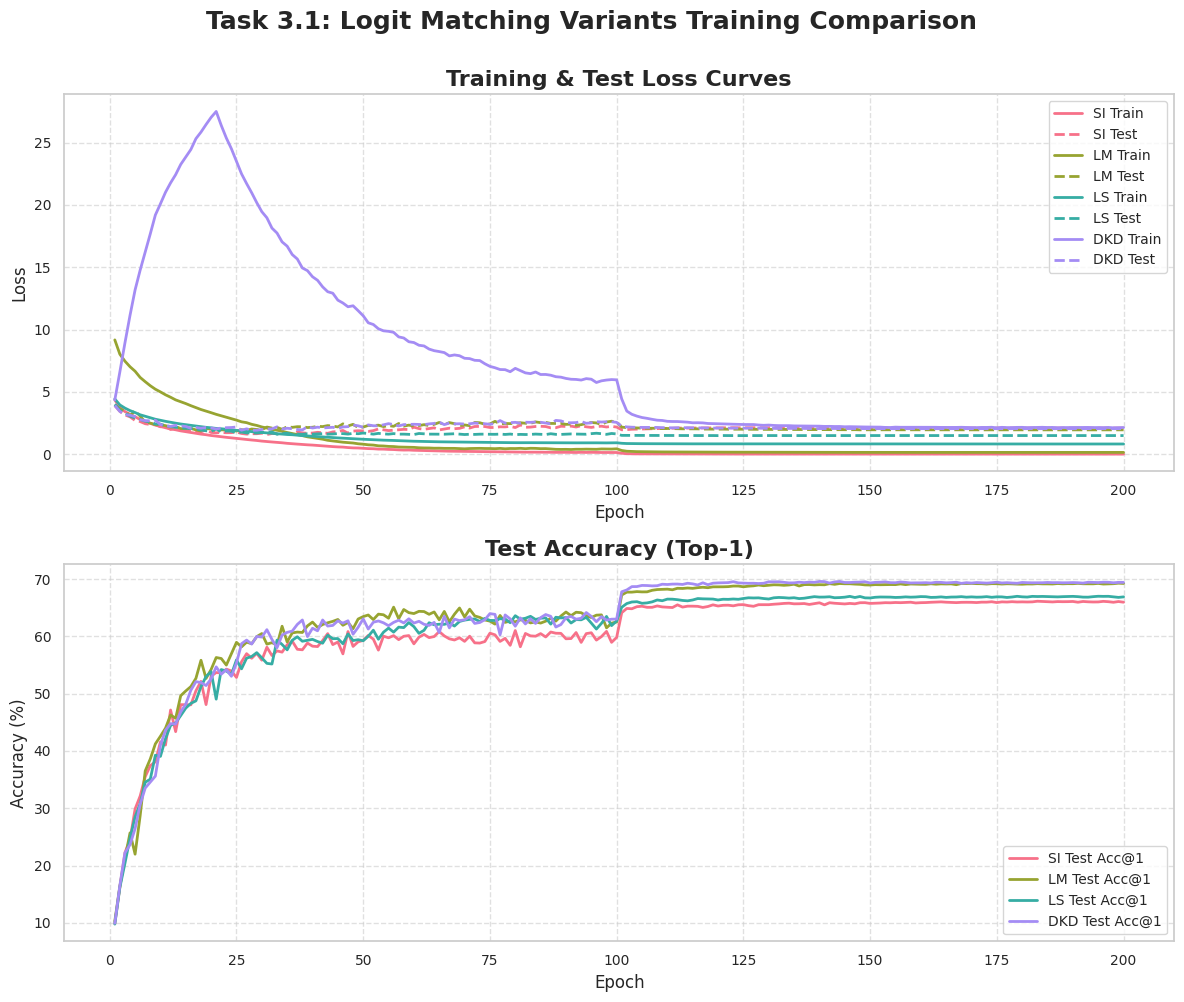

In [10]:
# ============================================
# 📊 Results Summary & Visualization
# ============================================

summary_data = []
loaded_results = {}

# Add Teacher results
summary_data.append({
    'Model': 'Teacher (VGG-16)',
    'Method': 'N/A',
    'Best Test Acc@1 (%)': f"{teacher_acc1:.2f}",
    'Best Test Acc@5 (%)': f"{teacher_acc5:.2f}",
    'Training Time (min)': 'N/A' if 'teacher_training_time' not in globals() else f"{teacher_training_time/60:.2f}",
    'Inference (ms/batch)': 'N/A'
})

# Load student results from JSON files
for model_key, config in configs.items():
    results_path = LOG_DIR / f"{config['model_name']}_results.json"
    if results_path.exists():
        with open(results_path, 'r') as f:
            results = json.load(f)
            loaded_results[model_key] = results
            summary_data.append({
                'Model': f"Student (VGG-11) - {model_key}",
                'Method': model_key,
                'Best Test Acc@1 (%)': f"{results['best_test_acc_top1']:.2f}",
                'Best Test Acc@5 (%)': f"{results['best_test_acc_top5']:.2f}",
                'Training Time (min)': f"{results['training_time_minutes']:.2f}",
                'Inference (ms/batch)': f"{results['avg_inference_time_ms_per_batch']:.2f}"
            })
    else:
        print(f"Warning: Results file not found for {model_key}")

summary_df = pd.DataFrame(summary_data)

print("\n--- Task 3.1 Results Summary ---")
print(summary_df.to_string(index=False))

# Save summary table
summary_df.to_csv(LOG_DIR / 'task3_1_summary.csv', index=False)
print(f"\n✅ Summary table saved to {LOG_DIR / 'task3_1_summary.csv'}")

# --- Plot Training Curves ---
print("\nGenerating training curves plot...")
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # Changed to 2x1

colors = sns.color_palette("husl", len(loaded_results))

for i, (model_key, results) in enumerate(loaded_results.items()):
    epochs_ran = len(results['history']['train_loss'])
    epoch_axis = range(1, epochs_ran + 1)

    # Plot Loss
    axes[0].plot(epoch_axis, results['history']['train_loss'], label=f'{model_key} Train', color=colors[i], linewidth=2)
    axes[0].plot(epoch_axis, results['history']['test_loss'], label=f'{model_key} Test', linestyle='--', color=colors[i], linewidth=2)

    # Plot Accuracy
    axes[1].plot(epoch_axis, results['history']['test_acc_top1'], label=f'{model_key} Test Acc@1', color=colors[i], linewidth=2)

axes[0].set_title('Training & Test Loss Curves', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=10)

axes[1].set_title('Test Accuracy (Top-1)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=10)

plt.suptitle('Task 3.1: Logit Matching Variants Training Comparison', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plot_save_path = FIGURE_DIR / 'task3_1_training_curves.png'
plt.savefig(plot_save_path, dpi=300)
print(f"✅ Training curves plot saved to {plot_save_path}")
plt.show()